# TimeSeries Analysis
Temperature Forecasting Example

In [17]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## 1- Load and Prepare Data

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-10-26 13:55:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.97.48, 52.217.14.38, 16.182.70.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.97.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.4MB/s    in 0.3s    

2023-10-26 13:55:31 (43.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420451, 15)

In [6]:
df.drop(columns='Date Time', inplace=True)

In [7]:
temperature = df['T (degC)']
raw_data = df

<Axes: >

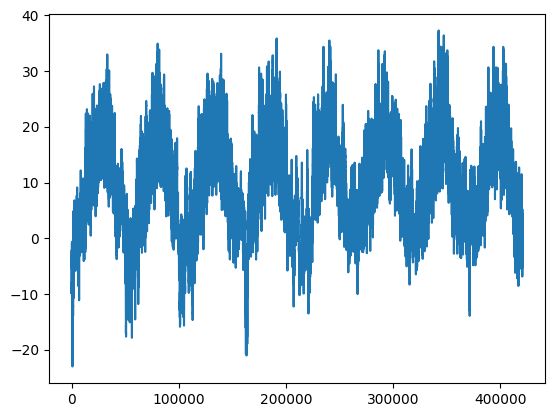

In [8]:
temperature.plot()

<Axes: >

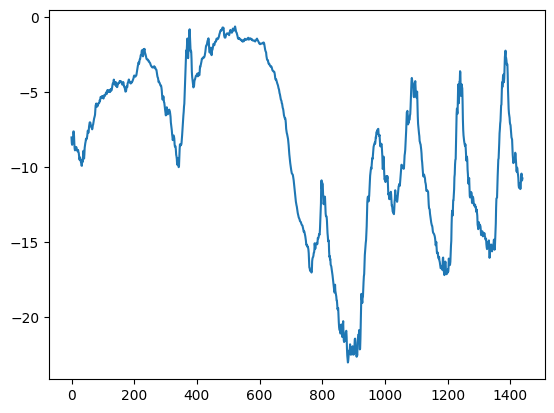

In [9]:
temperature[:1440].plot()

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

## 2- Normalization

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## 3- Create Train/Val/Test Datasets

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [13]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## 3- Reference Baseline

In [15]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## 5- Models

### 5-1. MLP Model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 57ms/step - loss: 12.6248 - mae: 2.7385 - val_loss: 12.4270 - val_mae: 2.7914


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
819/819 [==============================] - 47s 58ms/step - loss: 8.8782 - mae: 2.3451 - val_loss: 10.6026 - val_mae: 2.5693
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 8.2037 - mae: 2.2548 - val_loss: 12.6591 - val_mae: 2.8125
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 7.7031 - mae: 2.1843 - val_loss: 12.2069 - val_mae: 2.7684
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 7.3575 - mae: 2.1335 - val_loss: 11.9461 - val_mae: 2.7360
Epoch 6/10
819/819 [==============================] - 54s 65ms/step - loss: 7.1407 - mae: 2.1020 - val_loss: 13.2676 - val_mae: 2.8864
Epoch 7/10
819/819 [==============================] - 46s 55ms/step - loss: 6.9427 - mae: 2.0707 - val_loss: 11.3356 - val_mae: 2.6583
Epoch 8/10
819/819 [==============================] - 54s 65ms/step - loss: 6.7893 - mae: 2.0505 - val_loss: 11.0492 - val_mae: 2.6228
Epoch 9/10
819/819 [==============================] - 5

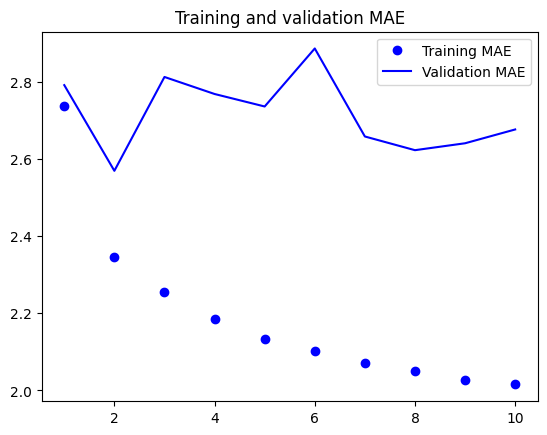

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-2. Conv Model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 55s 59ms/step - loss: 21.9433 - mae: 3.6874 - val_loss: 16.2180 - val_mae: 3.2004
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 15.8993 - mae: 3.1837 - val_loss: 15.5946 - val_mae: 3.1492
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 14.7539 - mae: 3.0585 - val_loss: 16.3307 - val_mae: 3.2205
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 13.9472 - mae: 2.9687 - val_loss: 14.8443 - val_mae: 3.0510
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 13.3330 - mae: 2.8978 - val_loss: 14.9000 - val_mae: 3.0530
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 12.8045 - mae: 2.8378 - val_loss: 15.0010 - val_mae: 3.0316
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 12.3911 - mae: 2.7916 - val_loss: 13.8977 - val_mae: 2.9206
Epoch 8/10
819/819 [============================

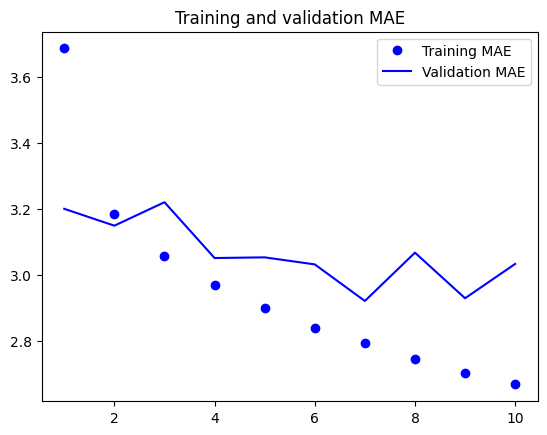

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-3. Simple LSTM-based Model

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 58s 65ms/step - loss: 40.8787 - mae: 4.6467 - val_loss: 12.5038 - val_mae: 2.6799
Epoch 2/10
819/819 [==============================] - 58s 71ms/step - loss: 10.9302 - mae: 2.5633 - val_loss: 9.2819 - val_mae: 2.3681
Epoch 3/10
819/819 [==============================] - 56s 69ms/step - loss: 9.7296 - mae: 2.4257 - val_loss: 9.4867 - val_mae: 2.3908
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 9.3063 - mae: 2.3710 - val_loss: 9.4990 - val_mae: 2.3856
Epoch 5/10
819/819 [==============================] - 51s 61ms/step - loss: 9.0053 - mae: 2.3333 - val_loss: 9.7313 - val_mae: 2.4220
Epoch 6/10
819/819 [==============================] - 53s 64ms/step - loss: 8.7089 - mae: 2.2940 - val_loss: 9.9596 - val_mae: 2.4485
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 8.5264 - mae: 2.2682 - val_loss: 9.6489 - val_mae: 2.4146
Epoch 8/10
819/819 [==============================] - 56s 6

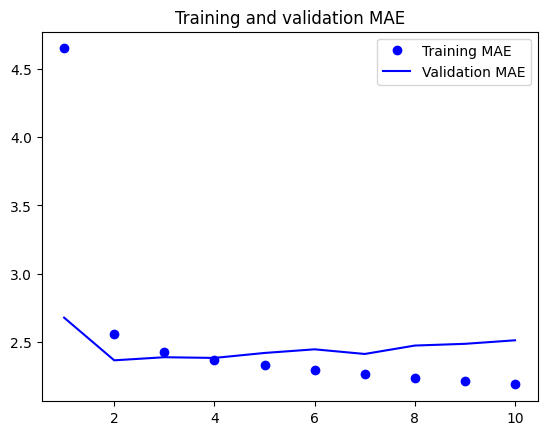

In [22]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 5-4. LSTM-based Model + Dropout

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 214s 252ms/step - loss: 28.9795 - mae: 3.9549 - val_loss: 9.8977 - val_mae: 2.4427


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
819/819 [==============================] - 201s 245ms/step - loss: 14.7859 - mae: 2.9869 - val_loss: 9.3581 - val_mae: 2.3793
Epoch 3/10
819/819 [==============================] - 199s 243ms/step - loss: 14.0456 - mae: 2.9052 - val_loss: 9.3054 - val_mae: 2.3702
Epoch 4/10
819/819 [==============================] - 213s 259ms/step - loss: 13.6013 - mae: 2.8520 - val_loss: 9.3298 - val_mae: 2.3724
Epoch 5/10
819/819 [==============================] - 200s 244ms/step - loss: 13.1015 - mae: 2.8005 - val_loss: 9.3751 - val_mae: 2.3728
Epoch 6/10
819/819 [==============================] - 199s 242ms/step - loss: 12.7405 - mae: 2.7608 - val_loss: 9.1213 - val_mae: 2.3458
Epoch 7/10
819/819 [==============================] - 211s 257ms/step - loss: 12.4465 - mae: 2.7270 - val_loss: 9.2871 - val_mae: 2.3732
Epoch 8/10
819/819 [==============================] - 199s 243ms/step - loss: 12.0369 - mae: 2.6878 - val_loss: 9.4679 - val_mae: 2.4084
Epoch 9/10
819/819 [=====================

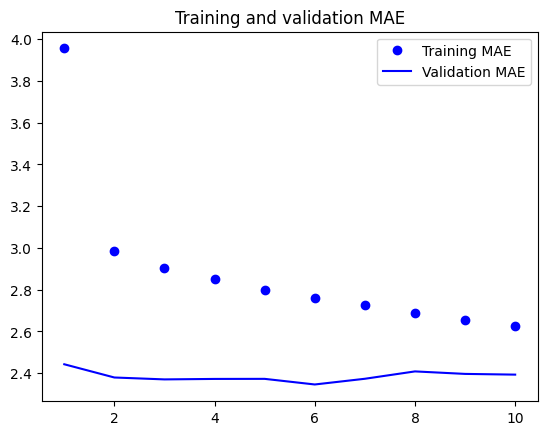

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()